In [835]:
%load_ext autoreload
%autoreload 2

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [836]:
# for easy conversion of units
unit = 1

# radius and location of the sphere
radius = 0.5 * unit
center = [0, 0, 0]

# permittivity of the sphere
epsr = 4

# set center frequency and wavelength
#f0 = 1e9
#wavelength = td.C_0 / f0

# free space central wavelength
#wavelength = (2 * radius) * 0.1
wavelength = (2 * radius) * 1.2
f0 = td.C_0 / wavelength

print(wavelength, f0)

# buffer between the sphere and the start of the PML layers
buffer_PML = 3 * wavelength
#buffer = radius

# buffer between the sphere and the near field monitor
#buffer_mon = buffer_PML / 2
#buffer_mon = radius / 2
buffer_mon = 0.5 * wavelength

# Define material properties
air = td.Medium(permittivity=1)
diel = td.Medium(permittivity=epsr)

# resolution control
grids_per_wavelength = 25
#grids_per_wavelength = 40

# Number of PML layers to use along each direction
npml = grids_per_wavelength

# create the sphere
sphere = td.Structure(geometry=td.Sphere(center=center, radius=radius), medium=td.PEC)
geometry = [sphere]
#geometry = []


1.2 249827048817455.7


## Process Geometry

Next we need to do conversions to get the problem parameters ready to define the simulation.

In [837]:
# grid size (um)
dl = wavelength / grids_per_wavelength

# Define PML layers
pml_layers = 3*[td.PML()]

# Compute the domain size in x, y, and z

domain_size = buffer_PML + 2 * radius + buffer_PML

# construct simulation size array
sim_size = (domain_size, domain_size, domain_size)

In [838]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

# place the source above the sphere (z+), propagating downwards (along z-)
source = td.PlaneWave(
    center=(0,0,radius + 3 * buffer_PML / 4),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction='-',
    pol_angle=np.pi)

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 40 / fwidth


In [839]:
# create a volume monitor around the sphere
mon_size = 2 * radius + 2 * buffer_mon
#mon_size = wavelength
monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[mon_size, mon_size, mon_size],
    freqs=[f0],
    name='near_field')

# get the surface monitors associated with the volume monitor
monitors = monitor.surfaces()


## Create Simulation

Now we can put everything together and define a simulation class to be run



In [840]:
sim = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    pml_layers=pml_layers
)

sim_empty = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=[],
    sources=[source],
    monitors=monitor.surfaces(),
    run_time=run_time,
    pml_layers=pml_layers
)

/Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/components/simulation.py:372: RuntimeWarning: divide by zero encountered in double_scalars
  lambda_min = C_0 / f_average / n_material


## Visualize Geometry

Lets take a look and make sure everything is defined properly


/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<Figure size 1440x576 with 6 Axes>

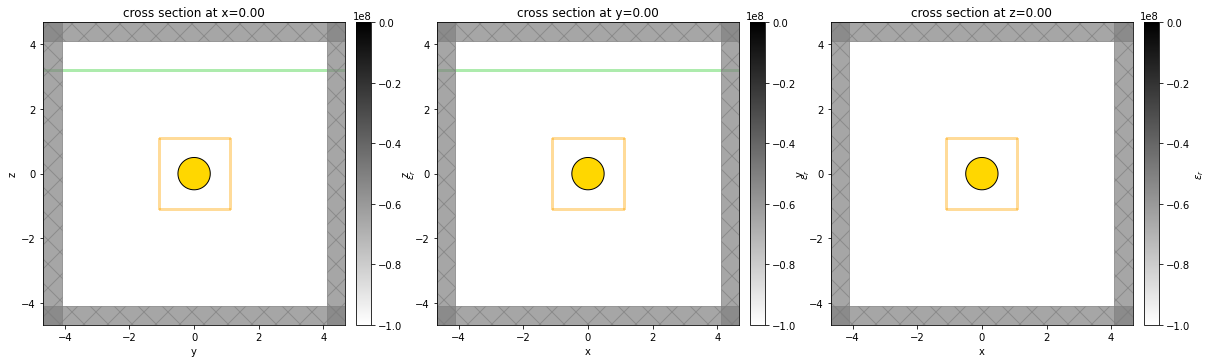

<Figure size 1440x576 with 6 Axes>

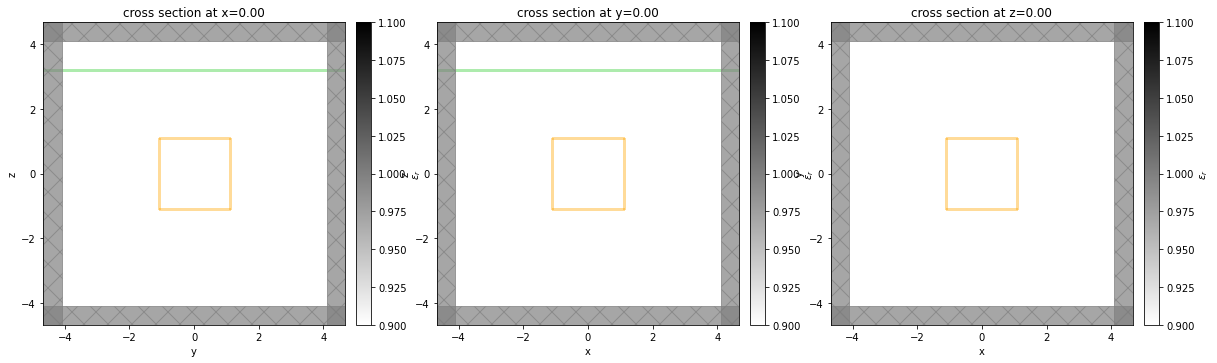

In [841]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
sim.plot_eps(x=0, ax=ax1);
sim.plot_eps(y=0, ax=ax2);
sim.plot_eps(z=0, ax=ax3);

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
sim_empty.plot_eps(x=0, ax=ax1);
sim_empty.plot_eps(y=0, ax=ax2);
sim_empty.plot_eps(z=0, ax=ax3);

## Run Simulation

Now we can run the simulation over time and measure the results to plot


In [842]:
# Run simulation
import tidy3d.web as web
sim_data = web.run(sim, task_name='sphereRCS', path='data/simulation.hdf5')
# sim_data = web.load('3e650fd4-548e-4556-b38a-e473c3c53eb7', sim, path='data/sphereRCS.hdf5')

sim_empty_data = web.run(sim_empty, task_name='sphereRCS_empty', path='data/sphereRCS_empty.hdf5')

import copy
sim_data_save = copy.deepcopy(sim_data)


[21:21:22] INFO     Uploaded task 'sphereRCS' with task_id                      ]8;id=804425;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=518767;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    'fb05b9cf-018d-495c-99b9-0b3c6a3ef726'.                                  

Output()

[21:21:23] status = queued                                                      ]8;id=966976;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=135727;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[21:21:41] status = preprocess                                                  ]8;id=682575;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=782472;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[21:22:33] status = postprocess                                                 ]8;id=341154;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=802432;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[21:22:39] status = success                                                     ]8;id=261160;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=446385;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[21:22:40] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=434813;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=604053;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "data/simulation.hdf5"                                                   

Output()

[21:22:42] INFO     loading SimulationData from data/simulation.hdf5            ]8;id=449334;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=609404;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#302\302]8;;\

[21:22:44] INFO     Uploaded task 'sphereRCS_empty' with task_id                ]8;id=662397;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=509064;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    '5928e331-4007-4537-a078-3904d7685b75'.                                  

Output()

[21:22:45] status = queued                                                      ]8;id=581507;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=592867;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[21:23:11] status = preprocess                                                  ]8;id=679571;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=981520;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[21:23:38] status = running                                                     ]8;id=177677;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=893010;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[21:24:02] status = postprocess                                                 ]8;id=698659;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=877324;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[21:24:09] status = success                                                     ]8;id=698381;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=302644;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#202\202]8;;\

[21:24:10] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=147566;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=813716;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#483\483]8;;\
                    "data/sphereRCS_empty.hdf5"                                              

Output()

[21:24:12] INFO     loading SimulationData from data/sphereRCS_empty.hdf5       ]8;id=437225;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=120317;file:///Users/shashwat/Documents/flexcompute/repos/tidy3d/tidy3d/web/webapi.py#302\302]8;;\

We now can inspect the field patterns on the area monitors using the Tidy3D built in field visualization methods.

<Figure size 1080x252 with 6 Axes>

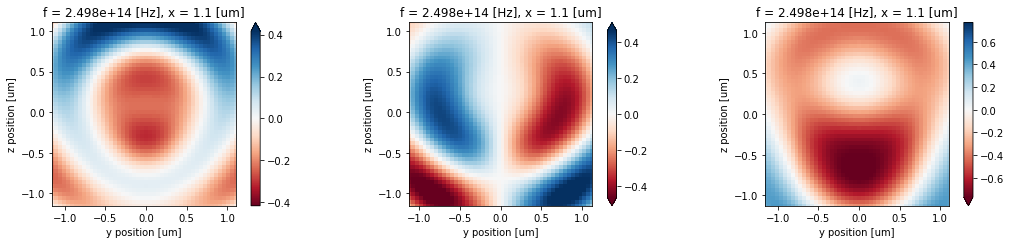

<Figure size 1080x252 with 6 Axes>

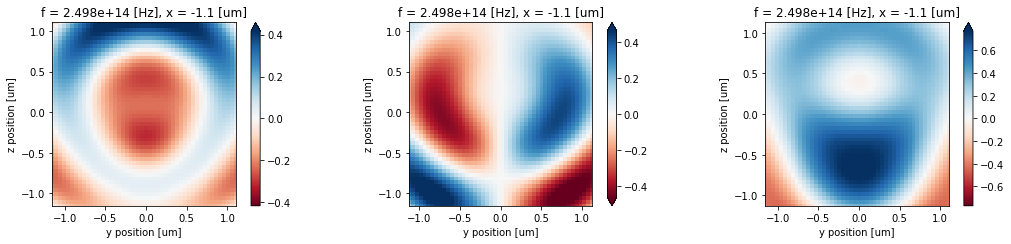

<Figure size 1080x252 with 6 Axes>

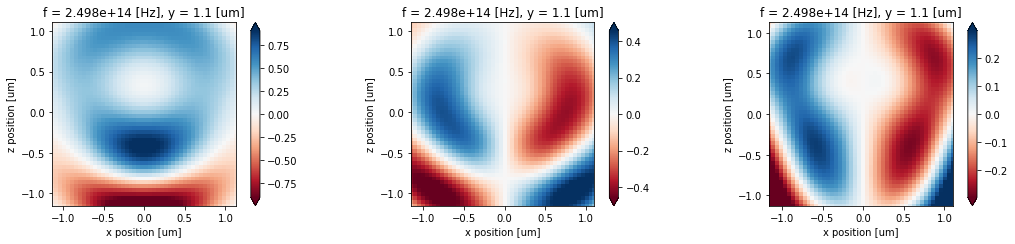

<Figure size 1080x252 with 6 Axes>

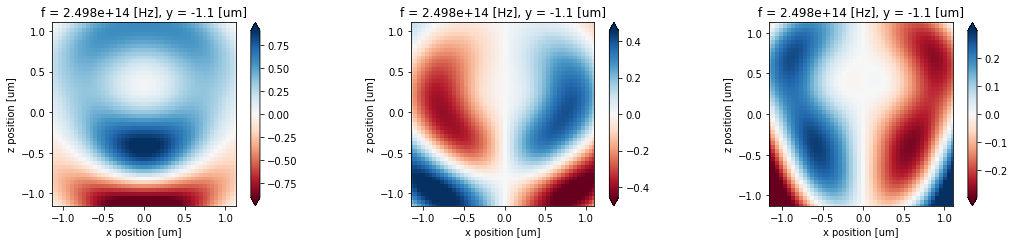

<Figure size 1080x252 with 6 Axes>

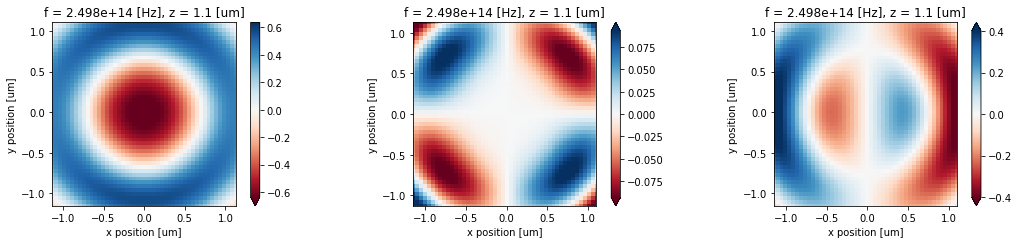

<Figure size 1080x252 with 6 Axes>

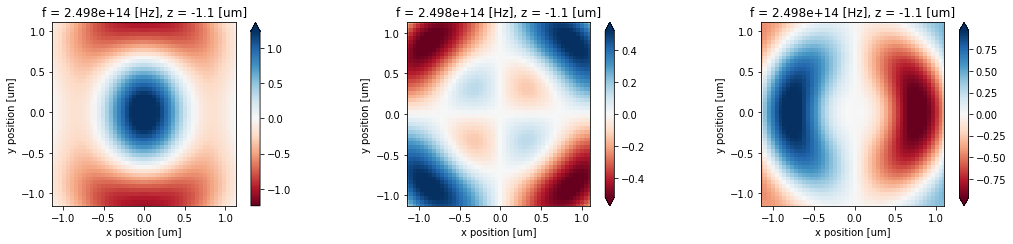

In [865]:

sim_data = copy.deepcopy(sim_data_save)

for mon in monitors:
    sim_data[mon.name].Ex -= sim_empty_data[mon.name].Ex
    sim_data[mon.name].Ey -= sim_empty_data[mon.name].Ey
    sim_data[mon.name].Ez -= sim_empty_data[mon.name].Ez

    sim_data[mon.name].Hx -= sim_empty_data[mon.name].Hx
    sim_data[mon.name].Hy -= sim_empty_data[mon.name].Hy
    sim_data[mon.name].Hz -= sim_empty_data[mon.name].Hz

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='near_field_x+', field_name='Ex', x=mon_size/2, val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_x+', field_name='Ey', x=mon_size/2, val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_x+', field_name='Ez', x=mon_size/2, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='near_field_x-', field_name='Ex', x=-mon_size/2, val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_x-', field_name='Ey', x=-mon_size/2, val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_x-', field_name='Ez', x=-mon_size/2, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='near_field_y+', field_name='Ex', y=mon_size/2, val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_y+', field_name='Ey', y=mon_size/2, val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_y+', field_name='Ez', y=mon_size/2, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='near_field_y-', field_name='Ex', y=-mon_size/2, val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_y-', field_name='Ey', y=-mon_size/2, val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_y-', field_name='Ez', y=-mon_size/2, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='near_field_z+', field_name='Ex', z=mon_size/2, val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_z+', field_name='Ey', z=mon_size/2, val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_z+', field_name='Ez', z=mon_size/2, val='real', freq=f0, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))

sim_data.plot_field(field_monitor_name='near_field_z-', field_name='Ex', z=-mon_size/2, val='real', freq=f0, ax=ax1)
sim_data.plot_field(field_monitor_name='near_field_z-', field_name='Ey', z=-mon_size/2, val='real', freq=f0, ax=ax2)
sim_data.plot_field(field_monitor_name='near_field_z-', field_name='Ez', z=-mon_size/2, val='real', freq=f0, ax=ax3)

plt.show()


In [866]:

import copy

from tidy3d.plugins import Near2Far

n2fmons = copy.deepcopy(monitors)
#del n2fmons[0:3]
n2f = Near2Far(sim_data, mons=n2fmons, frequency=f0)


In [867]:
# projection distance
far_distance = 200 * wavelength

num_theta = 300
num_phi = 2
thetas = np.linspace(0, np.pi, num_theta)
phis = np.linspace(0, np.pi/2, num_phi)

# initialize the far field values
RCS = np.zeros((num_theta, num_phi), dtype=complex)
E = np.zeros((num_theta, num_phi), dtype=complex)

from rich.progress import track

# loop through points in the output plane
for i in track(np.arange(len(thetas)), description='Performing far-field transformation...'):

    theta = thetas[i]
    for j in np.arange(len(phis)):
        phi = phis[j]

        # compute and store the outputs from projection function at the focal plane
        _RCS = n2f.radar_cross_section(theta, phi)
        RCS[i, j] = np.squeeze(_RCS)

        _E, _H = n2f.fields_spherical(far_distance, theta, phi)
        _E = np.linalg.norm(_E, 2)
        E[i, j] = np.squeeze(_E)
        
        #print(RCS[i, j], E[i, j])


Output()

/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/shashwat/Documents/flexcompute/repos/venvs/tidy3d-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/_0/6dn62bpx4nq02x1bthc1wthh0000gn/T/ipykernel_3931/902731606.py:48: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, which = 'both', axis = 'both', linewidth = 0.4)


<Figure size 540x360 with 1 Axes>

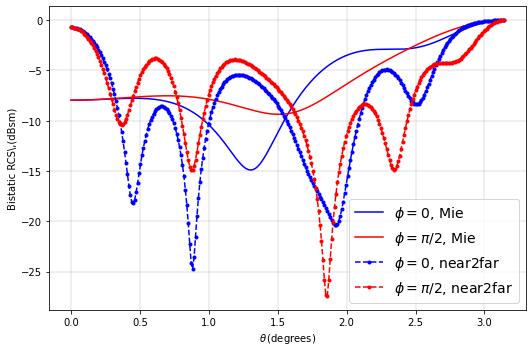

In [868]:
def scale_fn(val):
    val = val / np.max(np.abs(val))
    return 10.0*np.log10(val)

def plot_fn(val):
    return np.abs(val)

RCS_phi0 = scale_fn(np.squeeze(RCS[:,0]))
RCS_phi90 = scale_fn(np.squeeze(RCS[:,1]))

E_phi0 = scale_fn(plot_fn(np.squeeze(E[:,0])))
E_phi90 = scale_fn(plot_fn(np.squeeze(E[:,1])))

# import Mie data
#mie_filename = "./data/mie_bRCS_1m_epsr2_sigma1e7_f1e9.txt"

#mie_filename_phi0 = "./data/mie_bRCS_phi0_1m_epsr4.txt"
#mie_filename_phi90 = "./data/mie_bRCS_phi90_1m_epsr4.txt"

#mie_filename_phi0 = "./data/mie_bRCS_phi0_1m_pec.txt"
#mie_filename_phi90 = "./data/mie_bRCS_phi90_1m_pec.txt"

#mie_filename_phi0 = "./data/mie_bRCS_phi0_1m_air.txt"
#mie_filename_phi90 = "./data/mie_bRCS_phi90_1m_air.txt"

mie_filename_phi0 = "./data/mie_bRCS_phi0_1p2lamb_pec.txt"
mie_filename_phi90 = "./data/mie_bRCS_phi90_1p2lamb_pec.txt"

mie_data_phi0 = np.loadtxt(mie_filename_phi0, delimiter='\t', skiprows=2)
mie_theta_phi0 = np.squeeze(mie_data_phi0[:,[0]])
mie_phi0 = scale_fn(np.squeeze(mie_data_phi0[:,[1]]))

mie_data_phi90 = np.loadtxt(mie_filename_phi90, delimiter='\t', skiprows=2)
mie_theta_phi90 = np.squeeze(mie_data_phi90[:,[0]])
mie_phi90 = scale_fn(np.squeeze(mie_data_phi90[:,[1]]))

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_theta_phi0, mie_phi0, '-b', label="$\\phi = 0$, Mie")
ax.plot(mie_theta_phi90, mie_phi90, '-r', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, RCS_phi0, '.--b', label="$\\phi = 0$, near2far")
ax.plot(thetas, RCS_phi90, '.--r', label="$\\phi = \\pi/2$, near2far")
ax.set(xlabel = "$\\theta\\,$(degrees)",
       ylabel = "Bistatic RCS\\,(dBsm)",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(b = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

#fig, ax = plt.subplots(figsize=(7.5, 5))

#ax.plot(thetas, E_phi0, '-b', label="$\\phi = 0$")
#ax.plot(thetas, E_phi90, '-r', label="$\\phi = \\pi/2$")
#ax.set(xlabel = "$\\theta\\,$(degrees)",
#       ylabel = "|E|",
#       yscale = 'linear',
#       xscale = 'linear'
#      )
#ax.grid(b = True, which = 'both', axis = 'both', linewidth = 0.4)
#plt.legend(loc='best', prop={'size': 14})
#plt.tight_layout()

plt.show()

In [869]:
# projection distance
far_distance = 2000 * wavelength

num_x = 30
num_y = 30
x_n2f = domain_size * np.linspace(-0.5, 0.5, num_x)
y_n2f = domain_size * np.linspace(-0.5, 0.5, num_y)

# initialize the far field values
Es = np.zeros((3, num_x, num_y), dtype=complex)

from rich.progress import track

# loop through points in the output plane
for i in track(np.arange(len(x_n2f)), description='Performing far-field transformation...'):

    x = x_n2f[i]
    for j in np.arange(len(y_n2f)):
        y = y_n2f[j]

        # compute and store the outputs from projection function at the focal plane
        _E, _H = n2f.fields_cartesian(x, y, -far_distance)
        Es[:, i, j] = np.squeeze(_E)


Output()

<Figure size 720x360 with 6 Axes>

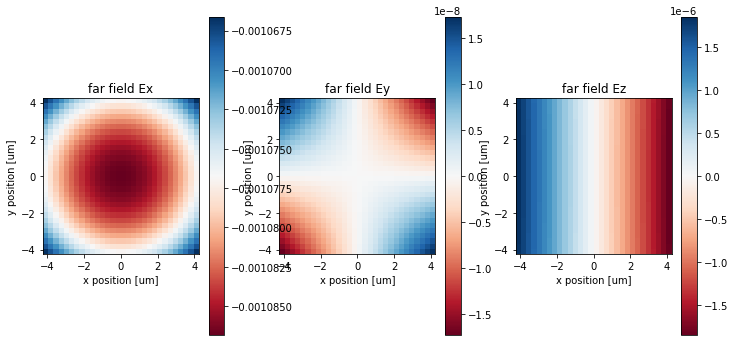

In [870]:
def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

func = 'real'
def plotfunc(val):
    return np.real(val)

fig, (axes) =  plt.subplots(1, 3)
fig.set_size_inches(10, 5)
fig.tight_layout()

for ax, direction, E in zip(axes, 'xyz', Es):
    im = pmesh(x_n2f, y_n2f, plotfunc(E), ax=ax, cmap='RdBu')
    ax.set_title(f'far field E{direction}')
    ax.set_aspect(1)
    ax.set_xlabel('x position [um]')
    ax.set_ylabel('y position [um]')
    plt.colorbar(im, ax=ax)
